In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from tqdm import tqdm
import matplotlib.pyplot as plt

### Factorization Machines

Consider a regression task with target variable as continuous. In Simple Linear Regression, we try to minimize the difference between true values and predicted values using Ordinary Least Squares (OLS). Here, we consider the predictor to be a linear combination of features. 

However, interactions are not limited to be linear. In order to model higher-order interactions for better predictibility, we should consider cross-features. So if we consider pairwise combinations, this will increase the complexity of model to $O(N^2)$ from originally $O(N)$.

\begin{equation}
\hat{y}(\mathbf{x})=w_{0}+\sum_{i=1}^{n} w_{i} x_{i}+\sum_{i=1}^{n} \sum_{j=i+1}^{n} w_{i} w_{j}x_{i} x_{j}
\end{equation}

Factorization Machines help in modelling the pairwise interactions efficiently. Every feature is represented as $K$-dimensional vector in latent space. This helps in reducing the number of weights from $O(N^2)$ to $O(KN)$. 

\begin{equation}
\hat{y}(\mathbf{x})=w_{0}+\sum_{i=1}^{n} w_{i} x_{i}+\sum_{i=1}^{n} \sum_{j=i+1}^{n}\left\langle\mathbf{v}_{i}, \mathbf{v}_{j}\right\rangle x_{i} x_{j}
\end{equation}

However, the time-complexity is still $O(N^2)$. We can reformulate the above equation as follows:

\begin{equation}
\hat{y}(\mathbf{x})=w_{0}+\sum_{i=1}^{n} w_{i} x_{i}+\frac{1}{2} \sum_{f=1}^{k}\left(\left(\sum_{i}^{n} v_{i, f} x_{i}\right)^{2}-\sum_{i=1}^{n} v_{i, f}^{2} x_{i}^{2}\right)
\end{equation}

This makes the time-complexity of model linear i.e. $O(KN)$.

In [2]:
dataset = load_diabetes()
df = pd.DataFrame(dataset['data'], columns=dataset['feature_names'])
df['target'] = dataset['target']

In [3]:
cols = df.columns.tolist()
cols.remove('target')

X = df[cols].values
Y = df['target'].values

X, X_val, Y, Y_val = train_test_split(X, Y, test_size=0.33, random_state=42)
X.shape, X_val.shape, Y.shape, Y_val.shape

((296, 10), (146, 10), (296,), (146,))

In [4]:
def get_prediction(x, w, b, M):
    cross_term = 0
    for v in M.T:
        cross_term += (v @ x)**2 - v**2 @ x**2
    cross_term /= 2
    prediction = b + w @ x + cross_term
    return prediction

def total_loss(Y, X, w, b, M):
    y_pred = list(map(lambda x: get_prediction(x, w, b, M), X))
    y_pred = np.array(y_pred)
    total_loss = np.sum((Y - y_pred)**2) / len(Y)
    return total_loss

def matrix_gradients(feature_idx, factor_idx, Y, X, w, b, M):
    y_pred = list(map(lambda x: get_prediction(x, w, b, M), X))
    y_pred = np.array(y_pred)

    const_sum = 0
    for v, x in zip(M.T[factor_idx], X.T):
        const_sum += v * x
    grad = X[:, feature_idx] * (const_sum - M[feature_idx, factor_idx] * X[:, feature_idx])
    fm_grad = -2 * (Y - y_pred) @ grad / len(Y)
    return fm_grad
        
def gradients(Y, X, w, b, M):
    N, k = M.shape

    y_pred = list(map(lambda x: get_prediction(x, w, b, M), X))
    y_pred = np.array(y_pred)

    db = -2 * np.sum(Y - y_pred) / len(Y)
    dw = np.array(list(map(lambda x: -2 * (Y - y_pred) @ x / len(Y), X.T)))

    fm_grad = list(map(lambda feature_idx: list(map(lambda factor_idx: matrix_gradients(feature_idx, factor_idx, Y, X, w, b, M), range(k))), range(N)))
    fm_grad = np.array(fm_grad)   
    return db, dw, fm_grad

In [5]:
def factorization_machine(Y, X, b_init, w_init, M_init, alpha, n_iters):
    costs = []

    b = b_init
    w = w_init
    M = M_init

    for _ in tqdm(range(n_iters)):
        db, dw, fm_grad = gradients(Y, X, w, b, M)
        b -= alpha * db
        w -= alpha * dw
        M -= alpha * fm_grad

        cost = total_loss(Y, X, w, b, M)
        costs.append(cost)

    return w, b, M, costs

100%|██████████| 200/200 [01:00<00:00,  3.30it/s]


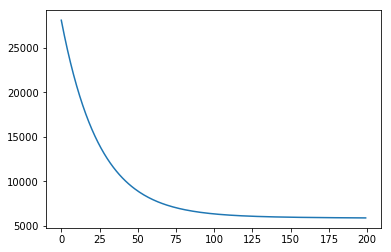

In [6]:
alpha = 1E-2 
n_iters = 200
num_factors = 5
b_init = 0.2
w_init = np.random.normal(size = (X.shape[1]))
M_init = np.random.normal(size = (X.shape[1], num_factors))

w, b, M, costs = factorization_machine(Y, X, b_init, w_init, M_init, alpha, n_iters)
plt.plot(costs)
plt.show()   

In [7]:
y_pred = list(map(lambda x: get_prediction(x, w, b, M), X_val))
y_pred = np.array(y_pred)
np.sqrt(mean_squared_error(Y_val, y_pred))

74.80727081843861